#  Q-learning

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Саттон Р.	С.,	Барто Э. Дж. Обучение с подкреплением: Введение. 2-е изд.
* https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/
* https://en.wikipedia.org/wiki/Q-learning
* https://www.baeldung.com/cs/epsilon-greedy-q-learning
* https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/
* https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial
* https://rubikscode.net/2021/07/20/introduction-to-double-q-learning/
* https://gymnasium.farama.org/api/wrappers/misc_wrappers/#gymnasium.wrappers.RecordVideo

## Задачи для совместного разбора

1\. Рассмотрите понятие Q-функции, ее применение для формирования политики агента и способов ее создания.

In [ ]:
import numpy as np

In [ ]:
actions = [0, 1]
states = [0, 1, 2]

q_table = np.random.uniform(0, 1, size=(len(states), len(actions)))

In [ ]:
q_table.shape

(3, 2)

In [ ]:
current_state = 1

q_table[current_state].argmax()

1

In [ ]:
states = np.array([
    [0.5, 1.5],
    [1.4, 2.1],
    [0.6, 1.1]
])

In [ ]:
states[:,0]

array([0.5, 1.4, 0.6])

In [ ]:
# закодировать
states = np.array([
    [0,],
    [1,],
    [0,]
])
# np digitize

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Обучите агента для игры в блэкджек (окружение `Blackjack-v1`), используя алгоритм Q-learning. Для создания таблицы Q-функции выясните размеры пространства состояния игры и количество возможных действий игрока и выведите эти значения на экран. Во время обучения несколько раз вычислите статистику за `print_every` последних эпизодов: количество выигранных и проигранных сессий. После завершения обучения визуализируйте полученные данные. Изучите, как выглядит Q-функция (в каких состояниях игрок будет брать карту, в каких - нет). Cыграйте `N=10000` игр, применяя стратегию, выведенную из обученной Q-функции, посчитайте и выведите на экран долю выигранных игр.

Cтратегия для выбора действия:
$$a_{t+1}(s_t) = argmax_aQ(s_t, a)$$

Правило обновления Q-функции:

![q-learning](https://wikimedia.org/api/rest_v1/media/math/render/svg/d247db9eaad4bd343e7882ec546bf3847ebd36d8)

- [ ] Проверено на семинаре

In [ ]:
from dataclasses import dataclass

@dataclass
class Config:
    discount: float = 0.95
    lr: float = 0.005
    n_episodes: float = 100_000
    print_every: int = 5000

In [ ]:
#!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.9 MB/s eta 0:00:00


In [ ]:
#!pip install ufal.pybox2d

In [ ]:
from collections import defaultdict

In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

class Agent:
    def __init__(self, env: gym.Env, config: Config) -> None:
        self.env = env
        self.config = config
        self._create_q_table()

    def _create_q_table(self):
        # напишите код для создания таблицы Q-функции
        # для окружения Blackjack должен получиться массив 32x11x2x2
        self.q_table = np.random.uniform(size=(32, 11, 2, 2))

    def get_action(self, state: np.ndarray) -> int:
        # найдите и верните индекс максимума Q-функции для состояния state
        # обратите внимание, что максимумов может быть несколько
        return np.argmax(self.q_table[state])

    def update_q_table(self, state: np.ndarray, new_state: np.ndarray, reward: float, action: int, done: bool) -> None:
        # напишите код для обновления Q-функции согласно правилу выше
        # если эпизод закончен, то будущая награда равна 0
        q_future = (not done) * np.max(self.q_table[new_state])
        self.q_table[state][action] = (1 - self.config.lr) * self.q_table[state][action] + self.config.lr * \
                                            (reward + self.config.discount * q_future)

    def run_episode(self) -> float:
        done = False
        state, info = self.env.reset()
        while not done:
            action = self.get_action(state)
            new_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            self.update_q_table(state, new_state, reward, action, done)
            state = new_state

            if done:
                return reward


    def train(self):
        # допишите код для сбора статистики
        ep_rewards , stats = [], []
        for ep in tqdm(range(self.config.n_episodes)):
            reward = self.run_episode()
            ep_rewards.append(reward)
            if ep % self.config.print_every == 0:
                rew = np.array(ep_rewards)
                stats.append(rew[rew == 1].sum() / self.config.print_every)
                ep_rewards = []
        return stats

In [ ]:
env = gym.make("Blackjack-v1")
observation, info = env.reset(seed=42)

In [ ]:
a = Agent(env, Config)
a.train()

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:12<00:00, 7755.51it/s]


[0.0,
 0.3152,
 0.3582,
 0.3716,
 0.3908,
 0.3882,
 0.3882,
 0.3956,
 0.388,
 0.386,
 0.4118,
 0.4006,
 0.39,
 0.4126,
 0.3994,
 0.3918,
 0.4034,
 0.4092,
 0.4154,
 0.3988]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_results(a):
    pairs = np.array(np.meshgrid(np.arange(12, 22), np.arange(1, 11))).T.reshape(-1, 2)
    res_noace = np.zeros((32, 12))
    res_ace = np.zeros((32, 12))
    for player_count, dealer_count in pairs:
        action1 = np.argmax(a.q_table[player_count, dealer_count, 0])
        action2 = np.argmax(a.q_table[player_count, dealer_count, 1])
        res_noace[player_count, dealer_count] = action1
        res_ace[player_count, dealer_count] = action2

    res_noace = res_noace[11:21, 1:-1]
    res_ace = res_ace[11:21, 1:-1]

    dct_res = {'With usable ace': res_noace,
               'Without usable ace': res_ace}

    fig, ax = plt.subplots(ncols=2)
    for idx, (title, res) in enumerate(dct_res.items()):
        sns.heatmap(res.T, annot=True, xticklabels=np.arange(12, 22)+1, yticklabels=np.arange(1, 11)+1, ax=ax[idx])
        ax[idx].set_ylabel('dealer count')
        ax[idx].set_xlabel('player_count')
        ax[idx].set_title(title)

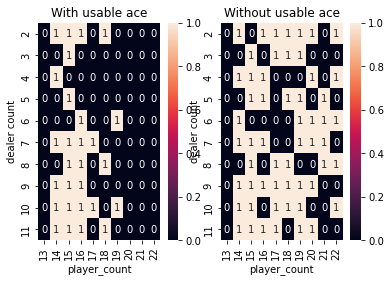

In [ ]:
plot_results(a)

In [ ]:
 def play_game(agent, N=10_000):
    env = gym.make("Blackjack-v1")
    observation, info = env.reset()

    win = 0
    for _ in range(N):
        observation, info = env.reset()
        done = False
        while not done:
            action = agent.get_action(observation)
            observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            if reward == 1:
                win += 1
    return win / N

In [ ]:
play_game(a)

0.4091

<p class="task" id="2"></p>

2\. Повторите решение предыдущей задачи, используя алгоритм $\epsilon$-greedy Q-learning. Исследуйте, как гиперпараметры и способ инициализации значений Q-функции влияют на результат.

Cтратегия для выбора действия:
1. Сгенерировать число $p$ из $U(0, 1)$;
2. Если $p < \epsilon$, то выбрать действие случайным образом;
3. В противном случае $a_{t+1}(s_t) = argmax_aQ(s_t, a)$.

Правило обновления Q-функции:
![q-learning](https://wikimedia.org/api/rest_v1/media/math/render/svg/d247db9eaad4bd343e7882ec546bf3847ebd36d8)

- [ ] Проверено на семинаре

In [ ]:
@dataclass
class Config:
    discount: float = 0.95
    lr: float = 0.005
    n_episodes: float = 100_000
    epsilon: float = 1
    final_epsilon: float = 0.3
    print_every: int = 5000

In [ ]:
class Agent_eps(Agent):
    def __init__(self, env: gym.Env, config: Config) -> None:
        super().__init__(env, config)

    def get_action(self, state: np.ndarray) -> int:
        p = np.random.uniform(0, 1)
        if p < self.config.epsilon:
            return env.action_space.sample()
        return np.argmax(self.q_table[state])

In [ ]:
agent2 = Agent_eps(env, Config)
agent2.train()

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:45<00:00, 2190.70it/s]


[0.0002,
 0.301,
 0.344,
 0.3722,
 0.3816,
 0.3834,
 0.3942,
 0.4016,
 0.3818,
 0.3948,
 0.3992,
 0.3938,
 0.3958,
 0.3994,
 0.383,
 0.4018,
 0.4054,
 0.4074,
 0.401,
 0.401]

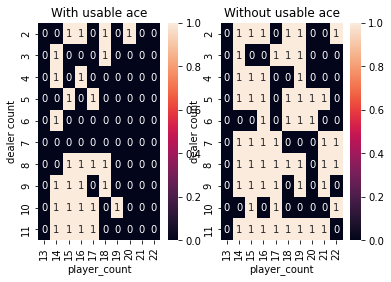

In [ ]:
plot_results(agent2)

In [ ]:
play_game(agent2)

0.4042

In [ ]:
agent2.q_table = np.random.normal(size=(32, 11, 2, 2))
agent2.train()
play_game(agent2)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:43<00:00, 2324.52it/s]


0.2791

In [ ]:
agent2.q_table = np.zeros((32, 11, 2, 2))
agent2.train()
play_game(agent2)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:43<00:00, 2281.85it/s]


0.2853

In [ ]:
agent2.q_table = np.ones((32, 11, 2, 2))
agent2.train()
play_game(agent2)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:43<00:00, 2294.57it/s]


0.2823

<p class="task" id="3"></p>

3\. Повторите решение задачи 1, используя алгоритм double Q-learning.

Cтратегия для выбора действия:
1. Сгенерировать число $p$ из $U(0, 1)$;
2. Если $p < \epsilon$, то выбрать действие случайным образом;
3. В противном случае $a_{t+1}(s_t) = argmax_a\left((Q^A_t + Q^B_t)(s_t, a))\right) $.

Правило обновления Q-функции:
$$
Q^A_{t+1}(s_{t}, a_{t}) = Q^A_{t}(s_{t}, a_{t}) + \alpha_{t}(s_{t}, a_{t}) \left(r_{t} + \gamma Q^B_{t}\left(s_{t+1}, {arg~max}_{a} Q^A_t(s_{t+1}, a)\right) - Q^A_{t}(s_{t}, a_{t})\right)
$$

$$
Q^B_{t+1}(s_{t}, a_{t}) = Q^B_{t}(s_{t}, a_{t}) + \alpha_{t}(s_{t}, a_{t}) \left(r_{t} + \gamma Q^A_{t}\left(s_{t+1}, {arg~max}_{a} Q^B_t(s_{t+1}, a)\right) - Q^B_{t}(s_{t}, a_{t})\right)
$$


- [ ] Проверено на семинаре

In [ ]:
@dataclass
class Config:
    discount: float = 0.95
    lr: float = 0.005
    n_episodes: float = 100_000
    epsilon: float = 0.1
    final_epsilon: float = 0.3
    print_every: int = 5000

In [ ]:
class Agent_double_Q(Agent):
    def __init__(self, env: gym.Env, config: Config) -> None:
        super().__init__(env, config)

    def _create_q_table(self):
        # напишите код для создания таблицы Q-функции
        # для окружения Blackjack должен получиться массив 32x11x2x2
        self.q_table_a = np.random.uniform(size=(32, 11, 2, 2))
        self.q_table_b = np.random.uniform(size=(32, 11, 2, 2))

    def get_action(self, state: np.ndarray) -> int:
        p = np.random.uniform(0, 1)
        if p < self.config.epsilon:
            return env.action_space.sample()
        return np.argmax(self.q_table_a[state] + self.q_table_b[state])

    def update_q_table(self, state: np.ndarray, new_state: np.ndarray, reward: float, action: int, done: bool) -> None:
        # напишите код для обновления Q-функции согласно правилу выше
        # если эпизод закончен, то будущая награда равна 0
        q_future_b = (not done) * self.q_table_b[new_state][np.argmax(self.q_table_a[new_state])]
        q_future_a = (not done) * self.q_table_a[new_state][np.argmax(self.q_table_b[new_state])]
        self.q_table_a[state][action] = self.q_table_a[state][action] + self.config.lr * \
                                            (reward + self.config.discount * q_future_b - self.q_table_a[state][action])
        self.q_table_b[state][action] = self.q_table_b[state][action] + self.config.lr * \
                                            (reward + self.config.discount * q_future_a - self.q_table_b[state][action])

In [ ]:
agent3 = Agent_double_Q(env, Config)
agent3.train()

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:48<00:00, 2078.67it/s]


[0.0002,
 0.3224,
 0.3656,
 0.3806,
 0.3848,
 0.3632,
 0.3828,
 0.3942,
 0.3808,
 0.39,
 0.406,
 0.3982,
 0.411,
 0.397,
 0.4076,
 0.4016,
 0.4008,
 0.4174,
 0.4006,
 0.3988]

In [ ]:
play_game(agent3)

0.4025

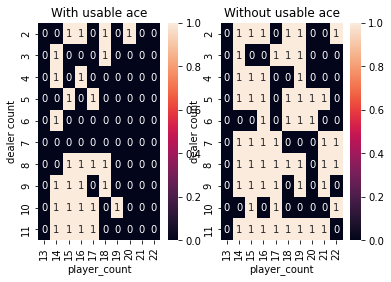

In [ ]:
plot_results(agent2)

<p class="task" id="4"></p>

4\. Обучите агента для управления машиной (окружение `MountainCar-v0`) при помощи любого из рассмотренных вариантов алгоритма Q-learning. Для перехода от непрерывного пространства состояний к конечному разбейте пространство состояний на окна (количество окон выберите сами). Для определения минимальных и максимальных значений координат воспользуйтесь [информацией об окружении](https://gymnasium.farama.org/environments/classic_control/mountain_car/#observation-space). Во время обучения несколько раз вычислите среднее значение наград за эпизод за несколько последних эпизодов и количество успешных сессий за последние эпизоды. После завершения обучения визуализируйте полученные данные.

Сделайте несколько промежуточных видео с записью работы агента во время обучения.

- [ ] Проверено на семинаре

In [ ]:
env = gym.make("MountainCar-v0")
observation, info = env.reset(seed=42)
env = gym.wrappers.RecordVideo(env, video_folder='mountaincar', video_length=200)

In [ ]:
@dataclass
class Config:
    discount: float = 0.95
    lr: float = 0.005
    n_episodes: float = 5_000
    epsilon: float = 0.1
    final_epsilon: float = 0.3
    print_every: int = 500

In [ ]:
class Mountain_Car_Agent(Agent):
    def __init__(self, env, config):
        super().__init__(env, config)
        self.bins1 = np.linspace(-1.2, 0.6, 15)
        self.bins2 = np.linspace(-0.7, 0.7, 15)

    def _create_q_table(self):
        self.q_table = np.random.uniform(-2, 0, size=(20, 20, 3))

    def run_episode(self) -> float:
        done = False
        state, info = self.env.reset()
        state1 = np.digitize(state[0], self.bins1)
        state2 = np.digitize(state[1], self.bins2)
        state = (state1, state2)
        rewards = 0
        while not done:
            action = self.get_action(state)
            new_state, reward, terminated, truncated, info = self.env.step(action)
            new_state1 = np.digitize(new_state[0], self.bins1)
            new_state2 = np.digitize(new_state[1], self.bins2)
            new_state = (new_state1, new_state2)
            done = terminated or truncated
            rewards += reward
            self.update_q_table(state, new_state, rewards, action, done)
            state = new_state

            if done:
                return rewards

    def train(self):
        # допишите код для сбора статистики
        ep_rewards , stats, mean_ep_rewards = [], [], []
        for ep in tqdm(range(self.config.n_episodes)):
            reward = self.run_episode()
            ep_rewards.append(reward)
            if ep % self.config.print_every == 0:
                env.render()
                rew = np.array(ep_rewards)
                mean_ep_rewards.append(rew.mean())
                stats.append(rew[rew == 1].sum() / self.config.print_every)
                ep_rewards = []
        return stats, mean_ep_rewards

In [ ]:
car = Mountain_Car_Agent(env, Config)
stats, mean_ep_rewards = car.train()

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:34<00:00, 23.31it/s]


In [ ]:
stats

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

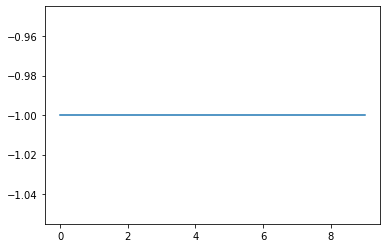

In [ ]:
plt.plot(mean_ep_rewards)

## Обратная связь
- [x] Хочу получить обратную связь по решению